## Adrien Libert & Arthur Courtrai

# Livre d'expériences


Thèmes abordés :
 - sql avancé, statistique descriptive et profilage des données
 - datawarehouse, préparation et nettoyage des données
 - stockage en colonne, pour les bases de données et les fichiers 

Outils :
 - Notebook Python (avec jupysql pour les commandes magiques SQL)
 - DuckDB (via `SQLAlchemy` et le driver `duckdb-engine`). Une option alternative (moins riche mais standardisée) est la DB-API 2.0.
 - `matplotlib` (pour les figures). alt. : `plotly` (interactif)

Les __ressources indispensables__ (ouvrir un onglet de navigateur par point...):
 - la documentation [DuckDB](https://duckdb.org/docs/archive/0.9.2/)
 - la documentation [`jupysql`](https://jupysql.ploomber.io/en/latest/quick-start.html)
 - un mémo SQL, comme [`sql.sh`](https://sql.sh) voire, le diaporama du cours...
 - au besoin, la documentation [`plotly`](https://plotly.com/python/) ou [`matplotlib`](https://matplotlib.org/stable/index.html)


## 1. Configuration et tests

### Installation des dépendances

In [ ]:
# uncomment the following lines if required
#import os
#os.environ['http_proxy'] = "http://cache.etu.univ-nantes.fr:3128" 
#os.environ['https_proxy'] = "https://cache.etu.univ-nantes.fr:3128"
print('Set up the proxy')

Set up the proxy


In [2]:
# Install supporting libraries
#%pip install duckdb jupysql jupysql-plugin matplotlib duckdb-engine --upgrade --quiet
# Install only if you plan to play with plotly (rather than - or - combined with matplotlib)
#%pip install plotly ipywidgets --upgrade --quiet

In [3]:
# **plotly only** cell
# setting for plotly install. If you're not using it, please skip that cell 
# fix an issue: plotly does not display figure with the default renderder
# if the one given here does not render either, then try another one: https://plotly.com/python/renderers/
# warning: it may initially require two runs (of the plot cell) to display the figure... uh?!
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
#Test pour les graphes et exercice 4
!pip install scipy
!pip install os
!pip install shutil

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/c6/a1/357e4cd43af2748e1e0407ae0e9a5ea8aaaa6b702833c81be11670dcbad8/scipy-1.11.4-cp312-cp312-win_amd64.whl.metadata
  Using cached scipy-1.11.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp312-cp312-win_amd64.whl (43.7 MB)



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# **plotly only** cell
# test plotly install. If you're not using it, please skip that cell
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()  # fig only should works as well (no need for .show()) as the last statement of a cell

### Collecte des données

In [6]:
# Download CSV data from uncloud
from pathlib import Path
from urllib.request import urlretrieve

data_path = Path('data')
if not data_path.is_dir():
    data_path.mkdir()

# data files are stored in data/ dir
eco2mix_csv_file = data_path / "eco2mix-regional-cons-def.csv"
temperature_csv_file = data_path / "temperature-quotidienne-regionale.csv"

if not eco2mix_csv_file.is_file():
    urlretrieve(
        "https://uncloud.univ-nantes.fr/index.php/s/oxwLW7TogjTkWdQ/download/eco2mix-regional-cons-def.csv",
        eco2mix_csv_file,
    )

if not temperature_csv_file.is_file():
    urlretrieve(
        "https://uncloud.univ-nantes.fr/index.php/s/e6YYYf6deg8Sd7J/download/temperature-quotidienne-regionale.csv",
        temperature_csv_file,
    )

### Configuration et test de connexion avec la base de données duckdb

In [7]:
# connect to duckdb DB and activate magic SQL commands
from sqlalchemy import create_engine

# db file name, to be stored in the project dir (where jupyter-lab was lauched from)
eco2mix_db = Path("eco2mix.db")

# Load magic SQL commands
# From now on, %sql? or %sqlplot? or %sqlcmd? for help on that magic commands from jupyslq
%load_ext sql

duckdb_url = "duckdb:///" + str(eco2mix_db)
engine = create_engine(duckdb_url)

# create the connexion and give it a name (db-eco2mix) -> see the last cell to close the connexion.
%sql engine --alias db-eco2mix
# %sql duckdb:///:memory:

In [8]:
%config SqlMagic.autopandas = True
%config SqlMagic.short_errors = True

In [9]:
# export raw data from CSV to PARQUET file (through DuckDB!)
eco2mix_parquet_file = data_path / "eco2mix-regional-cons-def.parquet"

if not eco2mix_parquet_file.is_file():
    %sql COPY (SELECT * FROM '{{eco2mix_csv_file}}') TO '{{eco2mix_parquet_file}}' (FORMAT PARQUET, COMPRESSION ZSTD);

### Premiers pas avec SQL magique

In [10]:
# My very first SQL query, on the CSV file (as a regular table)
%sql SELECT * FROM '{{eco2mix_parquet_file}}' LIMIT 3

Running query in 'db-eco2mix'

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Column 30
0,27,Bourgogne-Franche-Comté,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,28,Normandie,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,53,Bretagne,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [11]:
%%sql
/* create a view to ease raw data parquet file queries */
DROP VIEW IF EXISTS eco2mix_parquet_view;
CREATE VIEW eco2mix_parquet_view AS (SELECT * FROM '{{eco2mix_parquet_file}}');

Running query in 'db-eco2mix'

,Success


In [12]:
%sql summarize eco2mix_parquet_view

Running query in 'db-eco2mix'

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,Code INSEE région,BIGINT,11,93,12,49.916666666666664,25.64000885723748,27,48,76,1980288,0.0%
1,Région,VARCHAR,Auvergne-Rhône-Alpes,Île-de-France,12,None,None,None,None,None,1980288,0.0%
2,Nature,VARCHAR,Données consolidées,Données définitives,2,None,None,None,None,None,1980288,0.0%
3,Date,DATE,2013-01-01,2022-05-31,3433,None,None,None,None,None,1980288,0.0%
4,Heure,VARCHAR,00:00,23:30,47,None,None,None,None,None,1980288,0.0%
5,Date - Heure,TIMESTAMP,2012-12-31 23:00:00,2022-05-31 21:30:00,163303,None,None,None,None,None,1980288,0.0%
6,Consommation (MW),BIGINT,720,15338,13271,4497.689549840527,2170.360919996075,2788,4110,5739,1980288,0.0%
7,Thermique (MW),BIGINT,-83,4293,4084,378.3493124190769,540.7519159405394,24,156,490,1980288,0.0%
8,Nucléaire (MW),BIGINT,-144,13632,13324,6232.624971757184,3043.2448189076486,3603,6187,8715,1980288,41.67%
9,Eolien (MW),BIGINT,-6,4900,4733,256.4869481562282,433.3763115317384,27,105,298,1980288,0.01%


In [13]:
%%sql --save raw_eco2mix_pdl_2022 --no-execute
/* avec le double '%%', toute la cellule est dévolue à du code SQL.
    Les commentaires sont donc des commentaires SQL.

    param --no-execute: prepare an SQL statement for future execution
    param --save <name>: save the statement in the variable <name>                                         
*/
select  "Date - Heure" as timestamp,
        "Consommation (MW)" as conso_mw, 
        COALESCE("Thermique (MW)", 0) as thermique_mw, 
        COALESCE("Eolien (MW)", 0) as eolien_mw
from eco2mix_parquet_view
where "Région" = 'Pays de la Loire' and "Date" > DATE '2022-01-01' 

Running query in 'db-eco2mix'

Skipping execution...

<Axes: title={'center': "Boxplot from 'raw_eco2mix_pdl_2022'"}>

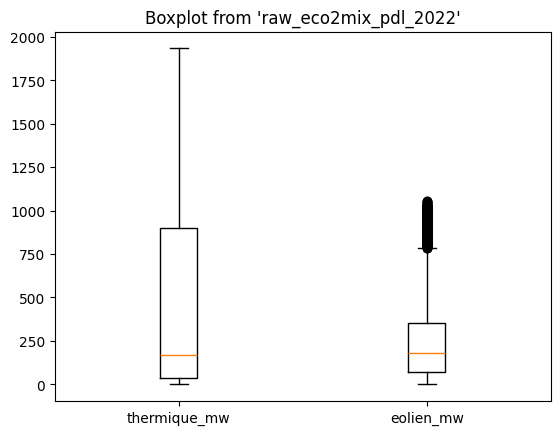

In [14]:
# with param: temp table, like a CTE
# table param: choose the data source. Combined with the `with` param, it can be a temporary table defined at runtime
# column param: series of attributes from the table, to plot in the boxplot
%sqlplot boxplot --column thermique_mw eolien_mw --table raw_eco2mix_pdl_2022 --with raw_eco2mix_pdl_2022

<Axes: title={'center': "Histogram from 'raw_eco2mix_pdl_2022'"}, ylabel='Count'>

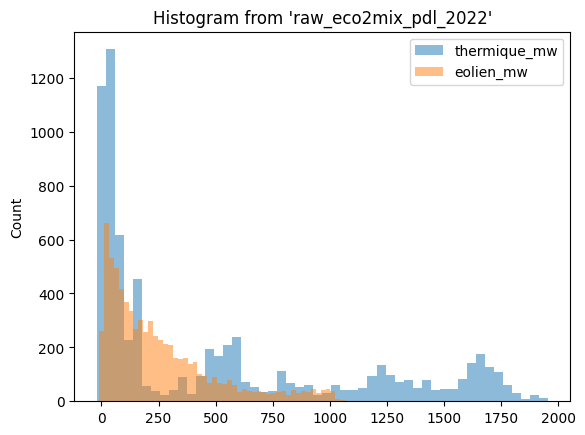

In [15]:
# dummy histogram plot, as an example.
%sqlplot histogram --column thermique_mw eolien_mw --table raw_eco2mix_pdl_2022 --with raw_eco2mix_pdl_2022

In [16]:
# test plotly capabilities against the actual eco2mix dataset
# build the result set from the registered query raw_eco2mix_pdl_2022
conso_df = %sql SELECT * from raw_eco2mix_pdl_2022

# draw usual linechart
fig = px.line(conso_df, x="timestamp", y="conso_mw", markers=False)
fig.show()

Generating CTE with stored snippets: 'raw_eco2mix_pdl_2022'

Running query in 'db-eco2mix'

## 2. Extraction et nettoyage des données éCO2mix

In [17]:
%%sql
/* 
    create the actual duckdb database table from the parquet file.

    Be curious: compare the size of the csv file vs. parquet file vs. db file. 
*/
drop table if exists eco2mix;
create table eco2mix
as select * from eco2mix_parquet_view;

Running query in 'db-eco2mix'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


### Pour visualiser la table eco2mix

In [18]:
%%sql
select * from eco2mix

Running query in 'db-eco2mix'

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Column 30
0,27,Bourgogne-Franche-Comté,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,28,Normandie,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,53,Bretagne,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
3,32,Hauts-de-France,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,75,Nouvelle-Aquitaine,Données définitives,2013-01-01,00:00,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980283,52,Pays de la Loire,Données consolidées,2022-05-31,23:30,2022-05-31 21:30:00,721.0,5.0,NaN,162.0,...,None,22.47,13.91,0.55,0.53,0.14,9.09,7.49,66.67,None
1980284,84,Auvergne-Rhône-Alpes,Données consolidées,2022-05-31,23:30,2022-05-31 21:30:00,6371.0,345.0,8558.0,12.0,...,63.07,0.19,1.75,0.02,0.07,63.05,35.08,1.66,55.5,None
1980285,44,Grand Est,Données consolidées,2022-05-31,23:30,2022-05-31 21:30:00,4525.0,1220.0,3724.0,585.0,...,34.42,12.93,14.24,0.0,0.0,24,46.99,2.7,47.84,None
1980286,75,Nouvelle-Aquitaine,Données consolidées,2022-05-31,23:30,2022-05-31 21:30:00,3692.0,28.0,2693.0,156.0,...,40.62,4.23,11.89,0.0,0.0,4.98,8.28,4.47,48.96,None


### statistiques de la base de donnée

In [19]:
%%sql 
summarize eco2mix;

Running query in 'db-eco2mix'

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,Code INSEE région,BIGINT,11,93,12,49.916666666666664,25.64000885723743,27,48,75,1980288,0.0%
1,Région,VARCHAR,Auvergne-Rhône-Alpes,Île-de-France,12,None,None,None,None,None,1980288,0.0%
2,Nature,VARCHAR,Données consolidées,Données définitives,2,None,None,None,None,None,1980288,0.0%
3,Date,DATE,2013-01-01,2022-05-31,3433,None,None,None,None,None,1980288,0.0%
4,Heure,VARCHAR,00:00,23:30,47,None,None,None,None,None,1980288,0.0%
5,Date - Heure,TIMESTAMP,2012-12-31 23:00:00,2022-05-31 21:30:00,163303,None,None,None,None,None,1980288,0.0%
6,Consommation (MW),BIGINT,720,15338,13271,4497.689549840527,2170.360919996089,2791,4110,5742,1980288,0.0%
7,Thermique (MW),BIGINT,-83,4293,4084,378.3493124190769,540.7519159405393,24,156,489,1980288,0.0%
8,Nucléaire (MW),BIGINT,-144,13632,13324,6232.624971757184,3043.2448189076576,3609,6190,8722,1980288,41.67%
9,Eolien (MW),BIGINT,-6,4900,4733,256.4869481562282,433.3763115317387,27,105,299,1980288,0.01%


## 1. Extraction et nettoyage des données

1) Suppression des attributs inutiles, ceux qui ont un taux de valeur à `null` supérieur à 70%, ainsi que les champs `Date` et `Heure` qui sont redondants avec le champ `Date - Heure`

On stocke dans une variable les statistiques, qui peuvent être interprétées par Pandas. On convertit les valeurs et on récupère juste les colonnes ayant un taux de valeurs nulles supérieur à 70%. On parcourt notre nouveau DataFrame, puis on supprime automatiquement les colonnes concernées.

Un simple ALTER TABLE est utilisé pour supprimer les colonnes Date et Heure.

Parmi les champs supprimés figurent les TCO et les TCH car None partout ou valeurs trés faible ainsi que taux > 70%

In [20]:
summarize = %sql summarize eco2mix;
summarize['null_percentage'] = summarize['null_percentage'].str.rstrip('%').astype('float')
summarize = summarize[summarize['null_percentage'] > 70]['column_name']
summarize = summarize.reset_index()
for row in summarize.itertuples():
    column_name = row.column_name
    query = f"ALTER TABLE eco2mix DROP COLUMN \"{column_name}\""
    %sql {{query}}
%sql ALTER TABLE eco2mix DROP COLUMN Date
%sql ALTER TABLE eco2mix DROP COLUMN Heure

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

,Success


2) Ajout d'une heure à toutes les valeurs de `Date - Heure` pour recaler le temps sur le fuseau UTC+01:00.


Un simple UPDATE avec un SET pour augmenter la Date - Heure de 1 heure

In [21]:
%%sql
UPDATE eco2mix
SET "Date - Heure" = "Date - Heure" + INTERVAL 1 HOUR;

Running query in 'db-eco2mix'

,Success


3) Suppression des premiers enregistrements du jeu de données, qui ne contiennent aucun relevé (consommation et production). Pourquoi ?

Un DELETE avec différentes conditions pour supprimer les lignes remplies de NA, les lignes n'apportant aucune information. On a juste la date, la région et l'heure, ce qui n'est d'aucun intérêt

In [22]:
%sql DELETE FROM eco2mix WHERE "Consommation (MW)" is null and "Thermique (MW)" is null and "Nucléaire (MW)" is null and "Eolien (MW)" is null and "Solaire (MW)" is null and "Hydraulique (MW)" is null and "Pompage (MW)" is null and "Bioénergies (MW)" is null and "Ech. physiques (MW)" is null;   ;

Running query in 'db-eco2mix'

,Success


4) Vérification/modification des types: les mesures de puissance sont des `integer`.

Aucun problème de type, BIGINT pour les entiers, VARCHAR pour les chaines de caractères

In [23]:
%%sql
SELECT COLUMN_NAME, DATA_TYPE 
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE TABLE_NAME = 'eco2mix'

Running query in 'db-eco2mix'

,column_name,data_type
0,Code INSEE région,BIGINT
1,Région,VARCHAR
2,Nature,VARCHAR
3,Date - Heure,TIMESTAMP
4,Consommation (MW),BIGINT
5,Thermique (MW),BIGINT
6,Nucléaire (MW),BIGINT
7,Eolien (MW),BIGINT
8,Solaire (MW),BIGINT
9,Hydraulique (MW),BIGINT


5) Ajout d'un champ calculé : production globale instantanée (en MW), nommé `Production (MW)`.

On ajoute une nouvelle colonne dans la table

In [24]:
%sql ALTER TABLE eco2mix ADD "Production (MW)" BIGINT

Running query in 'db-eco2mix'

,Success


On calcule la "Production (MW)" avec un SET et un COALESCE qui va prendre 

In [25]:
%%sql  
UPDATE eco2mix 
SET "Production (MW)" = COALESCE("Consommation (MW)", 0) + 
                        COALESCE("Thermique (MW)", 0) + 
                        COALESCE("Nucléaire (MW)", 0) + 
                        COALESCE("Eolien (MW)", 0) + 
                        COALESCE("Solaire (MW)", 0) + 
                        COALESCE("Hydraulique (MW)", 0) + 
                        COALESCE("Pompage (MW)", 0) + 
                        COALESCE("Bioénergies (MW)", 0) + 
                        COALESCE("Ech. physiques (MW)", 0);

Running query in 'db-eco2mix'

,Success


6) Consolidation (recalcul) des attributs TCO par filière (en % par rapport à la production globale instantanée). Les pourcentages sont de type `double`.

On construit les colonnes, puis on SET avec la formule

In [26]:
%%sql 
ALTER TABLE eco2mix ADD "TCO Thermique (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Nucléaire (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Eolien (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Solaire (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Hydraulique (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Pompage (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Bioénergies (MW)" DOUBLE;
ALTER TABLE eco2mix ADD "TCO Ech. physiques (MW)" DOUBLE;

Running query in 'db-eco2mix'

,Success


In [27]:
%%sql
UPDATE eco2mix
SET "TCO Thermique (MW)" = ROUND(("Thermique (MW)" / "Production (MW)") * 100, 2),
    "TCO Nucléaire (MW)" = ROUND(("Nucléaire (MW)" / "Production (MW)") * 100, 2),
    "TCO Eolien (MW)" = ROUND(("Eolien (MW)" / "Production (MW)") * 100, 2),
    "TCO Solaire (MW)" = ROUND(("Solaire (MW)" / "Production (MW)") * 100, 2),
    "TCO Hydraulique (MW)" = ROUND(("Hydraulique (MW)" / "Production (MW)") * 100, 2),
    "TCO Pompage (MW)" = ROUND(("Pompage (MW)" / "Production (MW)") * 100, 2),
    "TCO Bioénergies (MW)" = ROUND(("Bioénergies (MW)" / "Production (MW)") * 100, 2),
    "TCO Ech. physiques (MW)" = ROUND(("Ech. physiques (MW)" / "Production (MW)") * 100, 2);

SELECT * FROM eco2mix LIMIT 100;

Running query in 'db-eco2mix'

,Code INSEE région,Région,Nature,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),...,Ech. physiques (MW),Production (MW),TCO Thermique (MW),TCO Nucléaire (MW),TCO Eolien (MW),TCO Solaire (MW),TCO Hydraulique (MW),TCO Pompage (MW),TCO Bioénergies (MW),TCO Ech. physiques (MW)
0,52,Pays de la Loire,Données définitives,2013-01-01 00:30:00,3595,127,NaN,182,0,0,...,3252,7188,1.77,NaN,2.53,0.0,0.00,NaN,0.45,45.24
1,11,Île-de-France,Données définitives,2013-01-01 00:30:00,9134,685,NaN,16,0,0,...,8289,18266,3.75,NaN,0.09,0.0,0.00,NaN,0.78,45.38
2,24,Centre-Val de Loire,Données définitives,2013-01-01 00:30:00,2476,90,9085.0,508,0,34,...,-7267,4951,1.82,183.50,10.26,0.0,0.69,NaN,0.50,-146.78
3,44,Grand Est,Données définitives,2013-01-01 00:30:00,4943,319,9137.0,1109,0,1418,...,-7102,9881,3.23,92.47,11.22,0.0,14.35,0.00,0.58,-71.88
4,93,Provence-Alpes-Côte d'Azur,Données définitives,2013-01-01 00:30:00,5570,537,NaN,12,0,1412,...,3548,11137,4.82,NaN,0.11,0.0,12.68,0.00,0.52,31.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93,Provence-Alpes-Côte d'Azur,Données définitives,2013-01-01 04:00:00,4926,316,NaN,21,0,1028,...,3526,9851,3.21,NaN,0.21,0.0,10.44,0.00,0.35,35.79
96,93,Provence-Alpes-Côte d'Azur,Données définitives,2013-01-01 04:30:00,4970,316,NaN,22,0,1027,...,3569,9939,3.18,NaN,0.22,0.0,10.33,0.00,0.35,35.91
97,75,Nouvelle-Aquitaine,Données définitives,2013-01-01 04:30:00,4556,246,4208.0,99,0,273,...,-418,9109,2.70,46.20,1.09,0.0,3.00,NaN,1.59,-4.59
98,76,Occitanie,Données définitives,2013-01-01 04:30:00,4201,77,1583.0,95,0,621,...,2388,8396,0.92,18.85,1.13,0.0,7.40,-7.69,0.92,28.44


7) Le jeu de données contient-il encore des anomalies ou valeurs aberrantes ? Si oui, proposer des corrections supplémentaires.

Oui, on peut remplacer les NaN dans le jeu de donnée par des 0, pour éviter les conflits dans les requêtes suivantes
Egalement, on remplace  'Provence-Alpes-Côte ' Azur par = 'Provence-Alpes-Côte ''Azu pour éviter les conflits par la suite';


In [28]:
%%sql

UPDATE eco2mix
SET 
    "Thermique (MW)" = COALESCE("Thermique (MW)", 0),
    "Nucléaire (MW)" = COALESCE("Nucléaire (MW)", 0),
    "Eolien (MW)" = COALESCE("Eolien (MW)", 0),
    "Solaire (MW)" = COALESCE("Solaire (MW)", 0),
    "Hydraulique (MW)" = COALESCE("Hydraulique (MW)", 0),
    "Ech. physiques (MW)" = COALESCE("Ech. physiques (MW)", 0),
    "Production (MW)" = COALESCE("Production (MW)", 0),
    "Pompage (MW)" = COALESCE("Pompage (MW)", 0),
    "Bioénergies (MW)" = COALESCE("Bioénergies (MW)", 0),
    "TCO Thermique (MW)" = COALESCE("TCO Thermique (MW)", 0),
    "TCO Nucléaire (MW)" = COALESCE("TCO Nucléaire (MW)", 0),
    "TCO Eolien (MW)" = COALESCE("TCO Eolien (MW)", 0),
    "TCO Solaire (MW)" = COALESCE("TCO Solaire (MW)", 0),
    "TCO Hydraulique (MW)" = COALESCE("TCO Hydraulique (MW)", 0),
    "TCO Pompage (MW)" = COALESCE("TCO Pompage (MW)", 0),
    "TCO Bioénergies (MW)" = COALESCE("TCO Bioénergies (MW)", 0),
    "TCO Ech. physiques (MW)" = COALESCE("TCO Ech. physiques (MW)", 0);

UPDATE eco2mix
SET Région = 'Provence-Alpes-Côte d Azur'
WHERE Région = 'Provence-Alpes-Côte d''Azur';



Running query in 'db-eco2mix'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


## 2. Exploration

### Construire les requêtes SQL suivantes, avec éventuellement un rendu visuel (graphique). Tout _embellissement_ du résultat, dans la mesure où il améliore effectivement la lisibilité, sera apprécié (et donc valorisé).

Le résultat de chaque requête doit faire l'objet d'une brève interprétation textuelle. Si nécessaire, un complément d'investigation (une ou plusieurs requêtes supplémentaires, qui permettent une interprétation plus fine) peut être proposé pour approfondir un sujet.


__Remarque__: la puissance instantanée électrique (en MW) caractérise un "flux" électrique, comme une "vitesse" à un instant _t_. Pour avoir une mesure cumulée sur une durée (qu'on appelle __énergie__), il faut _multiplier_ par un temps. L'unité est donc le MWh (mégawatt-heure et non le MW/h). Par exemple, une puissance de 7 MW pendant 2 heures correspond à une énergie de 14 MWh.


1) __Groupement et agrégation simples__ : Production (en GWh) et consommation (en GWh), ainsi que leurs versions min, max et moyenne instantanées (en Mw), par mois et par région.

On utilise les agrégats classique de SQL pour cette requête

In [29]:
%%sql
SELECT 
    EXTRACT(MONTH FROM "Date - Heure") AS "Mois",
    "Région",
    SUM("Production (MW)" * 1/1000) AS Production_GWh,
    SUM("Consommation (MW)" * 1/1000) AS Consommation_GWh,
    MAX("Production (MW)") AS Max_Production_MW,
    MIN("Production (MW)") AS Min_Production_MW,
    AVG("Production (MW)") AS Moy_Production_MW,
    MAX("Consommation (MW)") AS Max_Consommation_MW,
    MIN("Consommation (MW)") AS Min_Consommation_MW,
    AVG("Consommation (MW)") AS Moy_Consommation_MW
FROM eco2mix
GROUP BY "Mois", "Région";

Running query in 'db-eco2mix'

,Mois,Région,Production_GWh,Consommation_GWh,Max_Production_MW,Min_Production_MW,Moy_Production_MW,Max_Consommation_MW,Min_Consommation_MW,Moy_Consommation_MW
0,2,Provence-Alpes-Côte d Azur,145791.839,77103.118,16661,4926,10770.673685,8331,3966,5696.152335
1,2,Occitanie,144666.859,72463.523,16976,5768,10687.563460,8488,3361,5353.392657
2,2,Nouvelle-Aquitaine,168182.609,83908.424,19130,7613,12424.838135,9565,3982,6198.908392
3,3,Provence-Alpes-Côte d Azur,146031.859,74984.252,15884,4428,9800.795906,7942,3459,5032.500134
4,3,Occitanie,140025.427,69565.054,14401,5272,9397.679664,7201,2606,4668.795570
...,...,...,...,...,...,...,...,...,...,...
139,11,Bourgogne-Franche-Comté,67144.777,35258.333,7770,2169,5180.924151,3887,1646,2720.550386
140,1,Pays de la Loire,112813.806,60500.475,12529,2815,7582.082532,6265,2219,4066.165401
141,1,Hauts-de-France,212860.724,106523.944,19191,8445,14306.117615,9598,4311,7159.348343
142,1,Bretagne,91962.728,50122.331,9812,2746,6180.706230,4914,1987,3368.662612


Les résultats permettent d'analyser les tendances saisonnières et régionales de la production et de la consommation d'énergie, ainsi que de détecter les périodes de pointe et les variations dans les besoins énergétiques.
Si la consommation est forte dans cette région ou la production, et vice-versa

Running query in 'db-eco2mix'

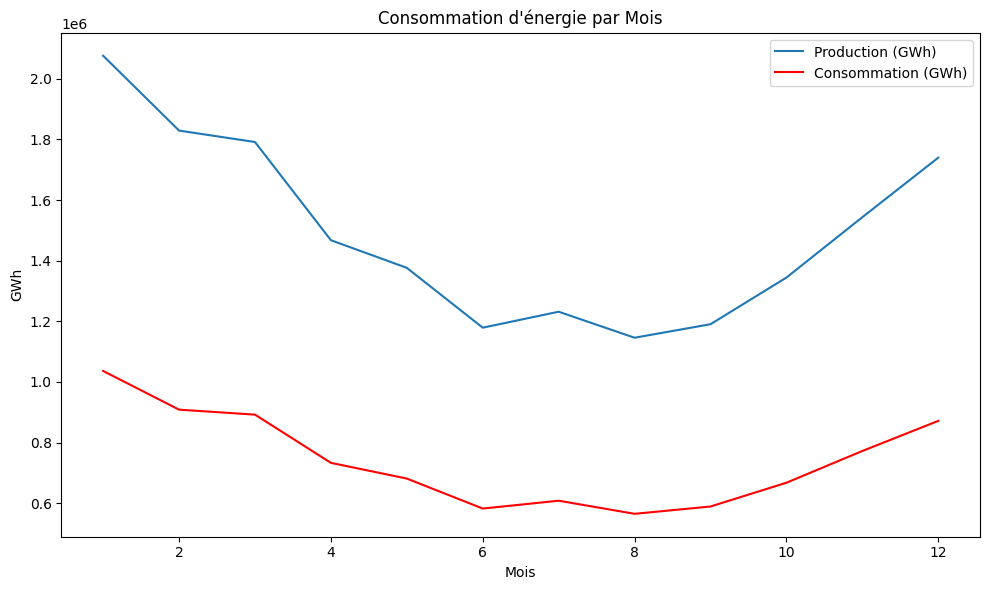

In [30]:
import matplotlib.pyplot as plt

df = %sql SELECT EXTRACT(MONTH FROM "Date - Heure") AS Mois, SUM("Production (MW)" * 1/1000) AS Production_GWh, SUM("Consommation (MW)" * 1/1000) AS Consommation_GWh FROM eco2mix GROUP BY Mois;

plt.figure(figsize=(10, 6))

plt.plot(df['Mois'], df['Production_GWh'], label='Production (GWh)')
plt.title('Production d\'énergie par Mois')
plt.xlabel('Mois')
plt.ylabel('GWh')
plt.legend()

plt.plot(df['Mois'], df['Consommation_GWh'], label='Consommation (GWh)', color='red')
plt.title('Consommation d\'énergie par Mois')
plt.xlabel('Mois')
plt.ylabel('GWh')
plt.legend()

plt.tight_layout()
plt.show()

Globalement, les graphiques sont semblables, mais il y a une différence d'échelle, la production est plus forte que la consommation.
Mais les graphiques sont presque corrélé.

Running query in 'db-eco2mix'

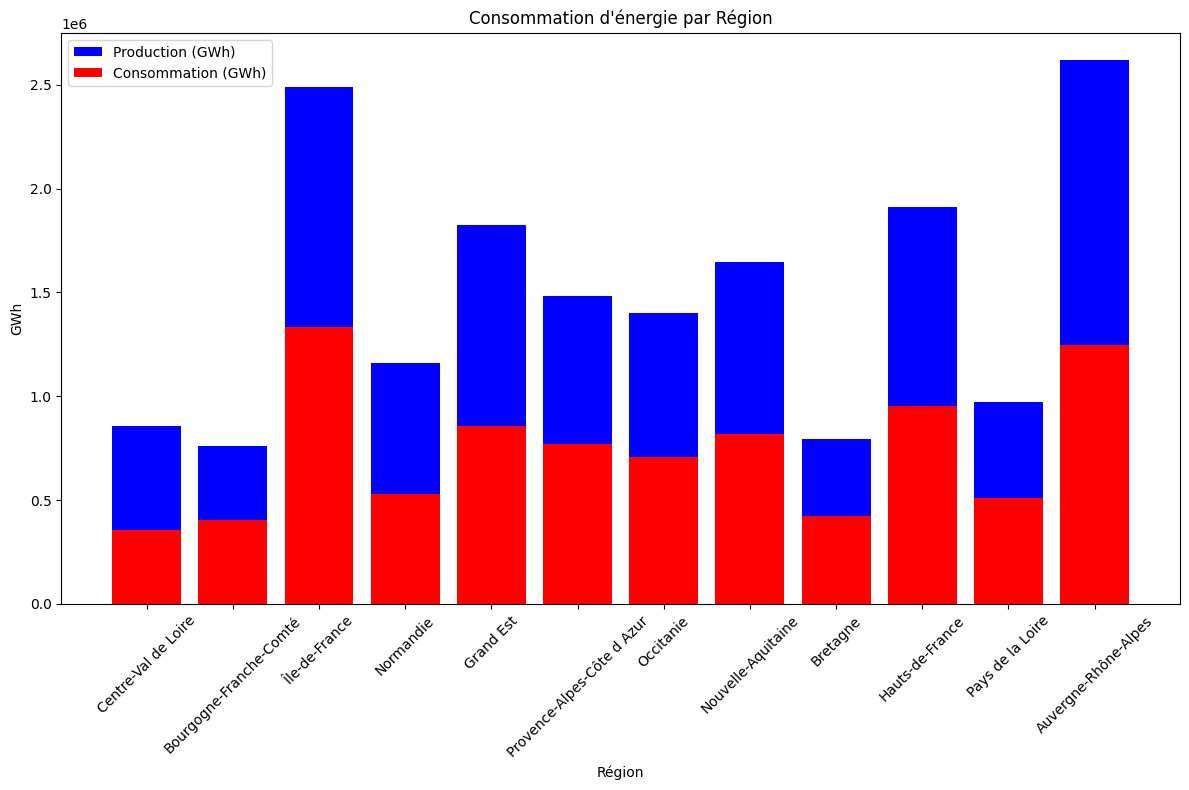

In [31]:
df = %sql SELECT "Région", SUM("Production (MW)" * 1/1000) AS Production_GWh, SUM("Consommation (MW)" * 1/1000) AS Consommation_GWh FROM eco2mix GROUP BY "Région";

plt.figure(figsize=(12, 8))

plt.bar(df['Région'], df['Production_GWh'], color='blue', label='Production (GWh)')
plt.title('Production d\'énergie par Région')
plt.xlabel('Région')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend()

plt.bar(df['Région'], df['Consommation_GWh'], color='red', label='Consommation (GWh)')
plt.title('Consommation d\'énergie par Région')
plt.xlabel('Région')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


Globalement les regions qui produisent le plus consomment le plus, mais également la production dépasse la consommation

2) __Pivot__ (construction `CASE WHEN THEN END`) : construire une table (résultat de requête) de la consommation (GWh) journalière montrant une colonne par région.
Par construction, chaque date devient une clé de la relation-résultat. Autrement dit, il y a une ligne de données de consommation pour chaque date.


In [32]:
%%sql
SELECT date_trunc('month', "Date - Heure") AS "DATE",
    SUM(CASE WHEN Région = 'Centre-Val de Loire' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Centre-Val de Loire",
    SUM(CASE WHEN Région = 'Bourgogne-Franche-Comté' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Bourgogne-Franche-Comté",
    SUM(CASE WHEN Région = 'Île-de-France' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Île-de-France",
    SUM(CASE WHEN Région = 'Normandie' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Normandie",
    SUM(CASE WHEN Région = 'Grand Est' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Grand Est",
    SUM(CASE WHEN Région = 'Provence-Alpes-Côte d Azur' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Provence-Alpes-Côte d Azur",
    SUM(CASE WHEN Région = 'Occitanie' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Occitanie",
    SUM(CASE WHEN Région = 'Nouvelle-Aquitaine' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Nouvelle-Aquitaine",
    SUM(CASE WHEN Région = 'Pays de la Loire' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Pays de la Loire",
    SUM(CASE WHEN Région = 'Hauts-de-France' THEN "Consommation (MW)" else 0END) * 0.5 * 0.001 AS "Hauts-de-France",
    SUM(CASE WHEN Région = 'Bretagne' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Bretagne"
FROM eco2mix
GROUP BY "DATE"
ORDER BY "DATE";

Running query in 'db-eco2mix'

,DATE,Centre-Val de Loire,Bourgogne-Franche-Comté,Île-de-France,Normandie,Grand Est,Provence-Alpes-Côte d Azur,Occitanie,Nouvelle-Aquitaine,Pays de la Loire,Hauts-de-France,Bretagne
0,2013-01-01,2209.4810,2352.4330,8413.2680,3248.4465,4866.2045,4599.0030,4309.1800,4914.0510,3061.6975,5528.2190,2527.8695
1,2013-02-01,2070.5030,2203.1275,7806.7245,3014.1295,4589.9165,4273.9990,3876.4120,4481.9990,2860.5750,5030.4295,2319.1060
2,2013-03-01,2036.3125,2194.2365,7801.8905,3149.7490,4703.8820,4142.7260,3693.8760,4332.1490,2888.4160,5252.1925,2460.3515
3,2013-04-01,1607.6215,1795.1125,6226.5320,2536.9565,3886.7060,3322.6630,3021.1495,3541.0005,2362.7415,4345.4105,2014.4720
4,2013-05-01,1434.7330,1722.2700,5574.0415,2228.3475,3618.8725,3070.7150,2728.5985,3341.1525,2029.8760,4105.7535,1680.8495
...,...,...,...,...,...,...,...,...,...,...,...,...
108,2022-01-01,2256.9920,2361.7280,7709.7840,2937.0945,4663.0875,4500.9340,4529.9525,5085.8765,3049.0955,5042.8250,2551.7095
109,2022-02-01,1825.1875,1962.2335,6343.1750,2523.6715,4016.0740,3595.7520,3450.3270,4000.1430,2483.4275,4326.4195,2154.2110
110,2022-03-01,1706.0935,1903.2990,6282.5690,2481.9125,4217.8585,3777.2200,3513.0250,3838.9635,2413.9865,4369.3980,2101.9570
111,2022-04-01,1460.1670,1645.5420,5486.8055,2190.2290,3564.9165,3054.0635,2985.1985,3422.2290,2092.9255,3940.0875,1787.7000



La requête SQL crée un tableau pivot montrant la consommation journalière d'énergie électriqu GWh) par région. Chaque ligne représente une date spécifique, et chaque colonne représente une région différente de France.
 Les valeurs de consommation sont calculées en utilisant SUM(CASE WHEN...) pour additionner la consommation d'énergie pour chaque région, avec une conversion de MW à GWh.
 Ce tableau permet de comparer la consommation d'énergie entre différentes régions pour chaque jour et d'observer les variations de consommation au fil du temps.

In [33]:
data = %sql SELECT date_trunc('month', "Date - Heure") AS "DATE",SUM(CASE WHEN Région = 'Centre-Val de Loire' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Centre-Val de Loire",SUM(CASE WHEN Région = 'Bourgogne-Franche-Comté' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Bourgogne-Franche-Comté",SUM(CASE WHEN Région = 'Île-de-France' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Île-de-France",SUM(CASE WHEN Région = 'Normandie' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Normandie",SUM(CASE WHEN Région = 'Grand Est' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Grand Est",SUM(CASE WHEN Région = 'Provence-Alpes-Côte d Azur' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS 'Provence-Alpes-Côte d Azur',SUM(CASE WHEN Région = 'Occitanie' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Occitanie",SUM(CASE WHEN Région = 'Nouvelle-Aquitaine' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Nouvelle-Aquitaine",SUM(CASE WHEN Région = 'Pays de la Loire' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Pays de la Loire",SUM(CASE WHEN Région = 'Hauts-de-France' THEN "Consommation (MW)" else 0END) * 0.5 * 0.001 AS "Hauts-de-France",SUM(CASE WHEN Région = 'Bretagne' THEN "Consommation (MW)" else 0 END) * 0.5 * 0.001 AS "Bretagne",FROM eco2mix, GROUP BY "DATE", ORDER BY "DATE";

Running query in 'db-eco2mix'

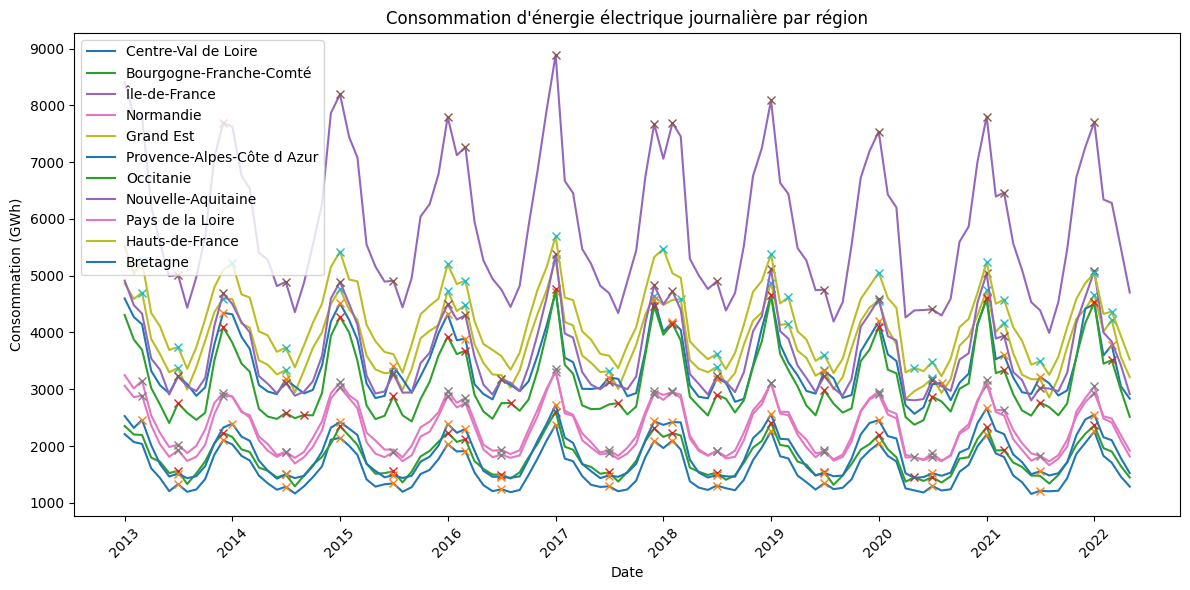

In [34]:
from scipy.signal import find_peaks
import pandas as pd

plt.figure(figsize=(12, 6))
for region in data.columns[1:]:
    plt.plot(data["DATE"], data[region], label=region)
    peaks, _ = find_peaks(data[region])
    plt.plot(data["DATE"].iloc[peaks], data[region].iloc[peaks], "x")

plt.title("Consommation d'énergie électrique journalière par région")
plt.xlabel("Date")
plt.ylabel("Consommation (GWh)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

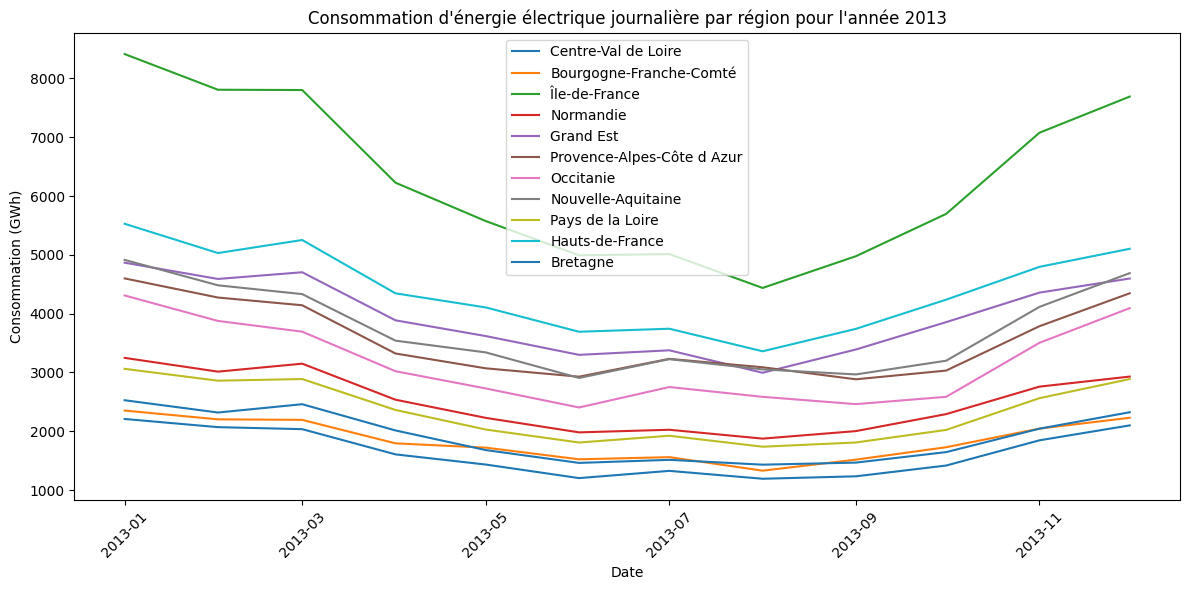

In [35]:
plt.figure(figsize=(12, 6))
data_2013 = data[data["DATE"].dt.year == 2013]
for region in data_2013.columns[1:]:
    plt.plot(data_2013["DATE"], data_2013[region], label=region)
    
plt.title("Consommation d'énergie électrique journalière par région pour l'année 2013")
plt.xlabel("Date")
plt.ylabel("Consommation (GWh)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

A l'aide des deux graphique, on constate des pics de consommations pendant les périodes de fin d'année dans chaque région

3) __Fenêtre glissante__ (_window function_ avec `RANGE`) : la consommation (GWh) du mois écoulé, chaque jour.

In [36]:
%%sql

WITH table_conso (Date, TotalConsommationGWh)
AS (
    SELECT date_trunc('day', "Date - Heure") AS "Date", SUM("Consommation (MW)" * 0.001 * 0.5) AS "TotalConsommationGWh"
    FROM
        eco2mix
    GROUP BY
        date_trunc('day', "Date - Heure"))
SELECT
    "Date",
    SUM("TotalConsommationGWh") OVER (
        ORDER BY "Date"
        RANGE BETWEEN INTERVAL '1' MONTH PRECEDING AND CURRENT ROW
    ) AS "Consommation GWh Mois Écoulé"
FROM table_conso
ORDER BY 1;

Running query in 'db-eco2mix'

,Date,Consommation GWh Mois Écoulé
0,2013-01-01,1278.2975
1,2013-01-02,2826.0945
2,2013-01-03,4425.4765
3,2013-01-04,5991.1760
4,2013-01-05,7434.5870
...,...,...
3433,2022-05-27,32751.4885
3434,2022-05-28,32521.2240
3435,2022-05-29,32289.0955
3436,2022-05-30,32230.6055


Le résultat montre une liste de dates avec la consommation totale en GWh le mois précédant pour chaque jour. 
Cette requête est utile pour analyser les tendances de consommation d'énergie sur une période d'un mois et voir comment la consommation évolue au fil du temps.

In [37]:
data = %sql WITH table_conso AS (SELECT date_trunc('day', "Date - Heure") AS "Date", SUM("Consommation (MW)" * 0.001 * 0.5) AS "TotalConsommationGWh" FROM eco2mix GROUP BY date_trunc('day', "Date - Heure")) SELECT "Date", SUM("TotalConsommationGWh") OVER (ORDER BY "Date" RANGE BETWEEN INTERVAL '1' MONTH PRECEDING AND CURRENT ROW) AS "Consommation GWh Mois Écoulé" FROM table_conso ORDER BY "Date";

Running query in 'db-eco2mix'

4) __Variation__ (_window function_, avec _CTE_ pour décomposer le calcul) : les 20 plus grands écarts de consommation quotidienne (GWh), d'un jour à l'autre.


In [38]:
%%sql

WITH table_conso (Date, TotalConsommationGWh)
AS (
    SELECT date_trunc('day', "Date - Heure") AS "Date", SUM("Consommation (MW)" * 0.001 * 0.5) AS "TotalConsommationGWh"
    FROM
        eco2mix
    GROUP BY
        date_trunc('day', "Date - Heure"))
SELECT
    "Date",
    ABS("TotalConsommationGWh" - LAG("TotalConsommationGWh",1,"TotalConsommationGWh" )
        OVER (ORDER BY "Date"))
        AS variation
FROM table_conso
ORDER BY variation DESC
LIMIT 20;

Running query in 'db-eco2mix'

,Date,variation
0,2018-10-29,313.5685
1,2015-01-05,297.5080
2,2013-03-11,292.9950
3,2021-02-08,287.1560
4,2016-01-23,284.4365
5,2018-11-19,282.7660
6,2017-11-13,281.6945
7,2017-11-06,279.6990
8,2016-11-07,278.5770
9,2018-02-26,278.5755


On utilise une CTE pour calculer la variation quotidienne de la consommation d'énergie électrique en gigawatt-heures (GWh), puis on sélectionne les 20 jours avec les plus grandes variations.
Les informations peuvent être utiles pour analyser les jours où il y a eu des changements significatifs dans la consommation d'énergie.

In [65]:
data = %sql WITH table_conso AS (SELECT date_trunc('day', "Date - Heure") AS "Date", SUM("Consommation (MW)" * 0.001 * 0.5) AS "TotalConsommationGWh" FROM eco2mix GROUP BY date_trunc('day', "Date - Heure")) SELECT "Date", ABS("TotalConsommationGWh" - LAG("TotalConsommationGWh", 1, "TotalConsommationGWh") OVER (ORDER BY "Date")) AS variation FROM table_conso ORDER BY variation DESC LIMIT 20

Running query in 'db-eco2mix'

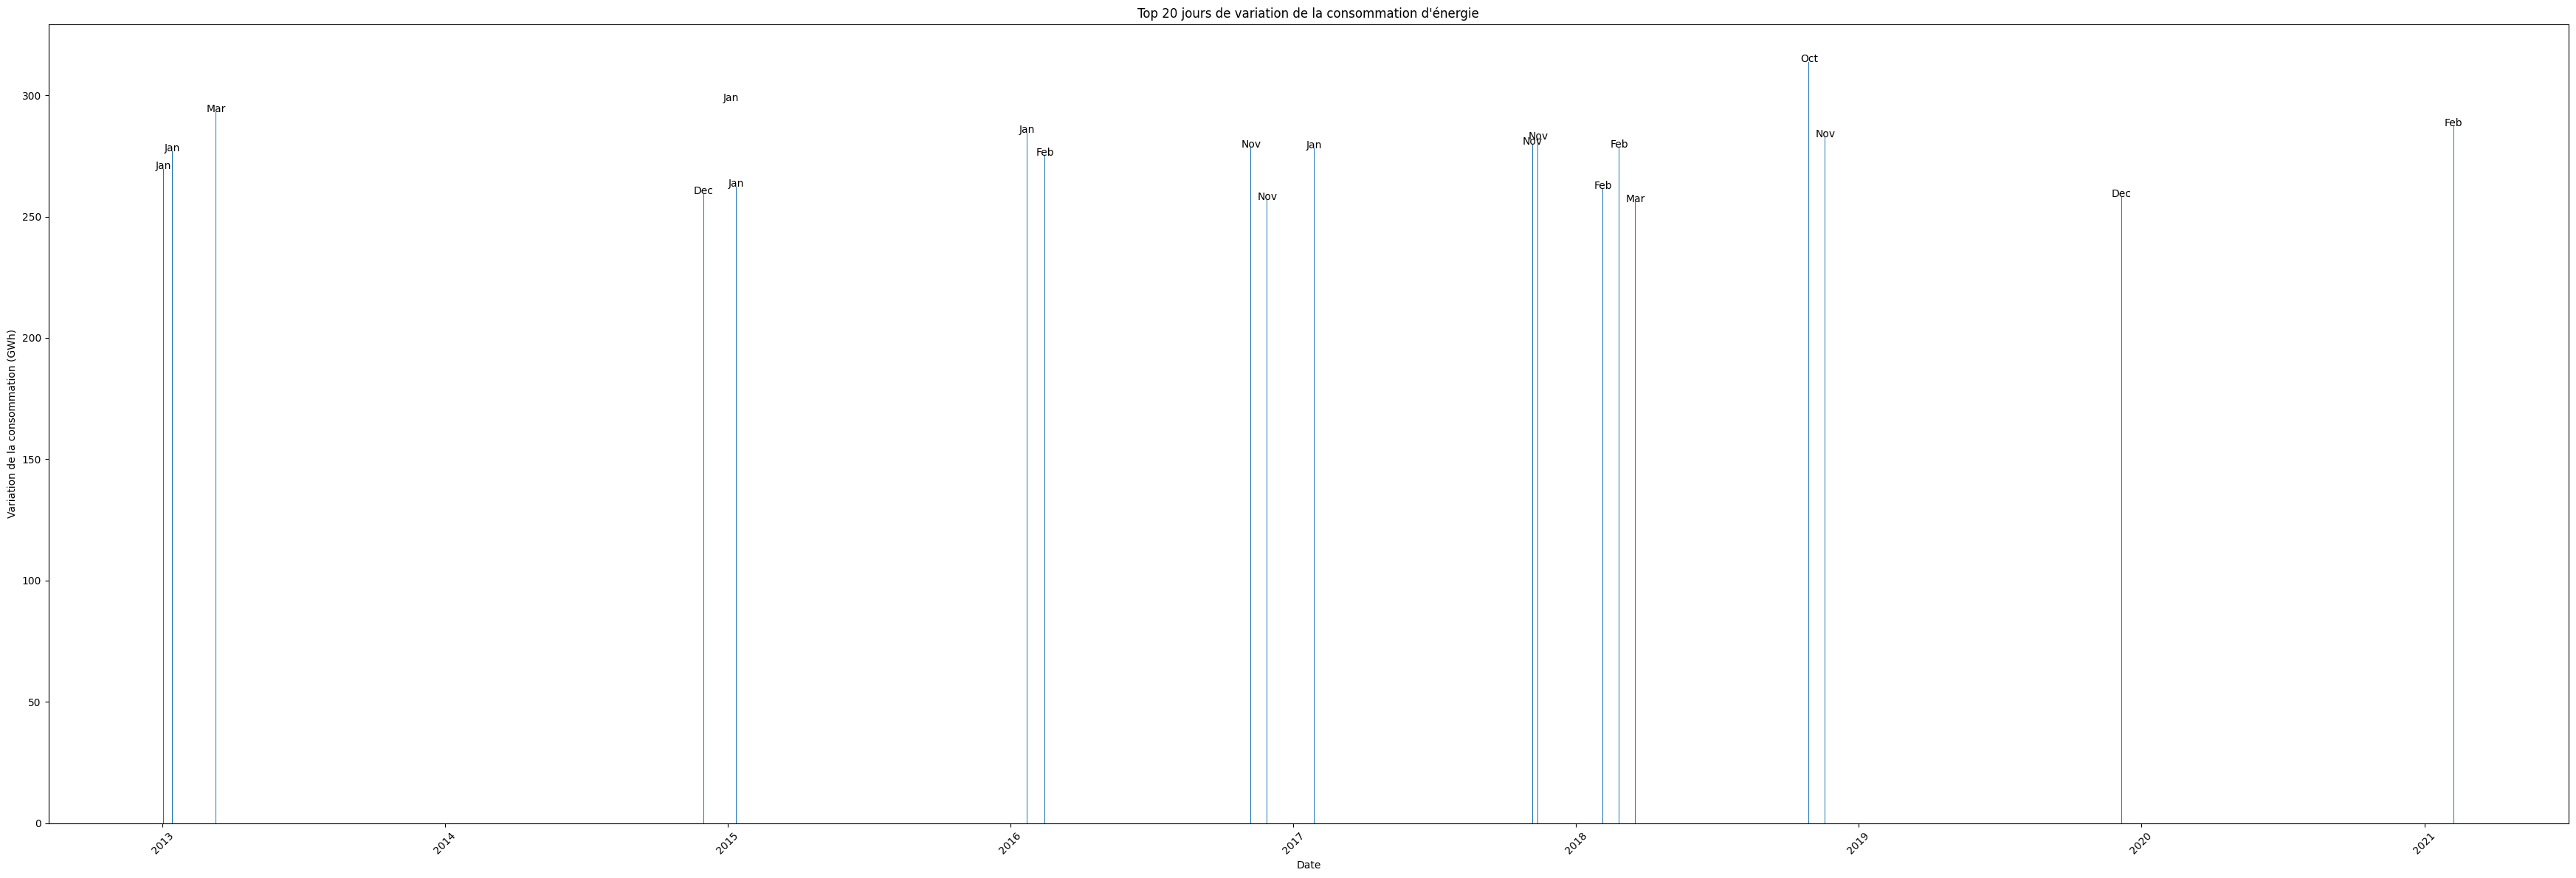

In [66]:
data["Date"] = pd.to_datetime(data["Date"])
    
plt.figure(figsize=(35, 12))
plt.bar(data["Date"], data["variation"])

for index, row in data.iterrows():
    plt.text(row["Date"], row["variation"], row["Date"].strftime('%b'), ha='center')

plt.title("Top 20 jours de variation de la consommation d'énergie")
plt.xlabel("Date")
plt.ylabel("Variation de la consommation (GWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## On remarque que les mois de janvier, décembre, février et novembre sont les plus fréquemment représentés, probablement parce qu'en hiver, les variations de consommation augmentent.

5) __Quantité cumulée__ (_window functions_ + _CTE_) : jour du dépassement des énergies renouvelables, pour chaque année (de 2013 à 2021). En d'autres termes, à quel moment de l'année (une date) la consommation atteint - dépassse - la production annuelle totale des filières renouvelables ?


In [41]:
%%sql

WITH renew AS (
    SELECT
        EXTRACT(year FROM "Date - Heure") AS annee,
        SUM("Hydraulique (MW)") + SUM("Bioénergies (MW)") + SUM("Eolien (MW)") + SUM("Solaire (MW)") + SUM("Hydraulique (MW)") + SUM("Pompage (MW)") AS production_annuelle
    FROM
        eco2mix
    GROUP BY
        EXTRACT(year FROM "Date - Heure")
),
daily AS (
    SELECT
        date_trunc('day', "Date - Heure") AS "Date",
        EXTRACT(year FROM "Date - Heure") AS annee,
        SUM("Consommation (MW)") AS daily_total
    FROM
        eco2mix
    GROUP BY
        date_trunc('day', "Date - Heure"), EXTRACT(year FROM "Date - Heure")
),
conso AS (
    SELECT
        "Date",
        annee,
        SUM(daily_total) OVER (
            PARTITION BY annee
            ORDER BY "Date"
        ) AS consommation_cumulee
    FROM
        daily
)
SELECT
    MIN(c."Date") as "Date",
    c.annee,
    (SELECT c.consommation_cumulee FROM conso c WHERE c."Date" = MIN(c."Date") AND c.annee = c.annee) as "Consommation",
    r.production_annuelle
FROM
    conso c
JOIN
    renew r ON c.annee = r.annee
WHERE
    c.consommation_cumulee >= r.production_annuelle
GROUP BY
    c.annee, r.production_annuelle
ORDER BY
    c.annee;


Running query in 'db-eco2mix'

,Date,annee,Consommation,production_annuelle
0,2013-04-11,2013,337420478.0,336794242.0
1,2014-04-18,2014,316430750.0,314237779.0
2,2015-04-01,2015,295341213.0,292895733.0
3,2016-04-12,2016,317958079.0,315716920.0
4,2017-03-30,2017,284132925.0,282798147.0
5,2018-04-24,2018,351903041.0,351352579.0
6,2019-04-22,2019,338024106.0,336297691.0
7,2020-05-21,2020,370495944.0,370380957.0
8,2021-04-30,2021,351780753.0,351543310.0
9,2022-02-15,2022,151446974.0,149853578.0


La requête SQL détermine le jour du dépassement des énergies renouvelables pour chaque année de 2013 à 2021.

La première CTE calcule la production annuelle totale des filières renouvelables (hydraulique, bioénergies, éolien, solaire et pompage) pour chaque année.
La deuxième CTE calcule la consommation totale d'énergie pour chaque jour.
La dernière CTE calcule la consommation cumulée d'énergie pour chaque jour de l'année, en sommant la consommation quotidienne.
La requête joint les CTE conso et renew pour obtenir la production annuelle des énergies renouvelables et la consommation cumulée correspondante.

La date de dépassement arrive toujours à peu près à la même période, en avril ou mai, sauf en 2022 où c'est en fé
vrier. À noter qu'en France, une part importante de la production est consacrée par le nucléaire, une énergie non renouvelable mais beaucoup moins polluante que certaines sources (panneaux solaires, éolien.ne...)

In [42]:
data = %sql WITH renew AS (SELECT EXTRACT(year FROM "Date - Heure") AS annee, SUM("Hydraulique (MW)") + SUM("Bioénergies (MW)") + SUM("Eolien (MW)") + SUM("Solaire (MW)") + SUM("Hydraulique (MW)") + SUM("Pompage (MW)") AS production_annuelle FROM eco2mix GROUP BY EXTRACT(year FROM "Date - Heure")), daily AS (SELECT date_trunc('day', "Date - Heure") AS "Date", EXTRACT(year FROM "Date - Heure") AS annee, SUM("Consommation (MW)") AS daily_total FROM eco2mix GROUP BY date_trunc('day', "Date - Heure"), EXTRACT(year FROM "Date - Heure")), conso AS (SELECT "Date", annee, SUM(daily_total) OVER (PARTITION BY annee ORDER BY "Date") AS consommation_cumulee FROM daily) SELECT MIN(c."Date") as "Date", c.annee, (SELECT c.consommation_cumulee FROM conso c WHERE c."Date" = MIN(c."Date") AND c.annee = c.annee) as "Consommation", r.production_annuelle FROM conso c JOIN renew r ON c.annee = r.annee WHERE c.consommation_cumulee >= r.production_annuelle GROUP BY c.annee, r.production_annuelle ORDER BY c.annee;
conso = %sql SELECT EXTRACT(year FROM "Date - Heure") AS "Annee",SUM("Consommation (MW)") AS "Consommation_Total" FROM eco2mix GROUP BY "Annee" ORDER BY "Annee";

Running query in 'db-eco2mix'

Running query in 'db-eco2mix'

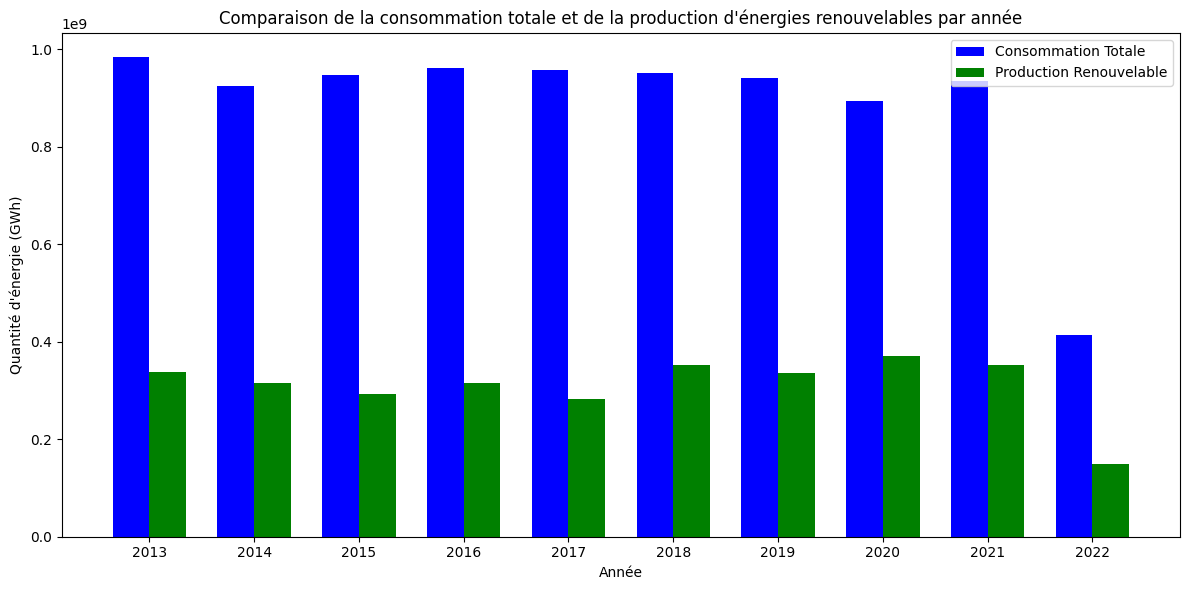

In [43]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = data["annee"]

plt.bar(index, conso["Consommation_Total"], bar_width, label="Consommation Totale", color='b')
plt.bar(index + bar_width, data["production_annuelle"], bar_width, label="Production Renouvelable", color='g')

plt.xlabel("Année")
plt.ylabel("Quantité d'énergie (GWh)")
plt.title("Comparaison de la consommation totale et de la production d'énergies renouvelables par année")
plt.xticks(index + bar_width / 2, index)
plt.legend()

plt.tight_layout()
plt.show()


On peut remarquer que la production renouvelable correspond à peu près à un tiers ou un quart de la consommation totale d'énergie.

6. __Calcul de point fixe__ (_CTE récursive_) : trouver toutes les périodes correspondant aux 3 plus longues séquences d'augmentation de la consommation instantanée. Voici un extrait (la première ligne) de résultat escompté :

| Date - Heure | Durée (hh:mm:ss) | 	Région    | Séquence (MW*) | Rang |
| :----------- | :---             | ---       | ---             | --- |
| 2016-07-18 02:30:00	| 11:00:00	| Île-de-France| [4616, 4646, 4661, 4715, 4942, 5009, 5391, 568...| 1 |

In [44]:
%%sql
WITH RECURSIVE seq AS (
    SELECT
        "Date - Heure",
        "Consommation (MW)",
        "Région",
        1 AS length,
        ARRAY["Consommation (MW)"] AS sequence
    FROM
        eco2mix
    UNION ALL
    SELECT
        e."Date - Heure",
        e."Consommation (MW)",
        e."Région",
        s.length + 1,
        array_append(s.sequence, e."Consommation (MW)")
    FROM
        eco2mix e
    INNER JOIN seq s ON e."Date - Heure" = s."Date - Heure" + INTERVAL '1 hour' AND e."Région" = s."Région"
    WHERE
        e."Consommation (MW)" > s."Consommation (MW)" 
)
, ranked_sequences AS (
    SELECT
        *,
        RANK() OVER (ORDER BY length DESC, "Date - Heure") as "Rang"
    FROM seq
)
SELECT
    "Date - Heure",
    LPAD(length::TEXT, 2, '0') || ':00:00' AS "Durée (hh:mm:ss)",
    "Région",
    sequence,
    "Rang"
FROM ranked_sequences
WHERE "Rang" <= 3
ORDER BY "Rang", "Date - Heure";

Running query in 'db-eco2mix'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Date - Heure,Durée (hh:mm:ss),Région,sequence,Rang
0,2015-07-01 11:30:00,13:00:00,Pays de la Loire,"[2080, 2090, 2155, 2185, 2227, 2329, 2514, 280...",1
1,2013-07-10 13:30:00,12:00:00,Nouvelle-Aquitaine,"[3549, 3556, 3798, 3897, 4179, 4599, 4958, 504...",2
2,2013-07-31 14:00:00,12:00:00,Provence-Alpes-Côte d Azur,"[3387, 3395, 3537, 3634, 3918, 4330, 4710, 480...",3



Pour la requête SQL, on utilise une CTE récursive pour trouver les trois plus longues séquences d'augmentation de la consommation instantanée d'énergie électrique dans différentes régions.
 On initialise les séquences à 1 avec la consommation du jour même, puis on les augmente si la consommation suivante est plus élevée que la précédente.

Chaque séquence est identifiée par la date et l'heure de début, la durée totale de la séquence, la région concernée, la séquence des valeurs de consommation en mégawatts (MW) et un rang indiquant la longueur relative de la séquence par rapport aux autres séquences.

Le résultat de la requête affiche les trois séquences les plus longues :

Première séquence : Démarre le 1er juillet 2015 à 11:30 dans la région des Pays de la Loire, avec une durée totale de 13 heures. La séquence des valeurs de consommation est indiquée, et cette séquence est classée en premier rang.

Deuxième séquence : Commence le 10 juillet 2013 à 13:30 en Nouvelle-Aquitaine, dure 12 heures et est classée au deuxième rang.

Troisième séquence : Débute le 31 juillet 2013 à 14:00 en Provence-Alpes-Côte d'Azur, également d'une durée de 12 heures, et se classe en troisième rang.

Ces résultats sont utiles pour analyser les périodes de forte demande d'énergie dans différentes régions et pour comprendre les tendances de la consommation énermmation.

7. __Construction du cube__ (`GROUP BY CUBE|GROUPING SETS|ROLLUP`) : donner toutes les valeurs de consommation (en GWh) agrégés par jour, par mois, par année et sur toute la période, ainsi que par région, par zone (NO, NE, SO, SE et IdF) et sur l'ensemble du territoire métropolitain (à l'exclusion de la Corse, non représentée dans le jeu de données). Toutes les combinaisons de ces 2 dimensions (temps et géographie) doivent figurer dans le résultat.

In [45]:
%%sql
WITH daily AS (
        SELECT
        EXTRACT(DAY FROM "Date - Heure") AS "Jour",
        EXTRACT(MONTH FROM "Date - Heure") AS "Mois",
        EXTRACT(YEAR FROM "Date - Heure") AS "Annee",
        "région",
        SUM("Consommation (MW)") * 0.5 * 0.001 AS daily_conso
    FROM
        eco2mix
    GROUP BY
        EXTRACT(DAY FROM "Date - Heure")  ,
        EXTRACT(MONTH FROM "Date - Heure"),
        EXTRACT(YEAR FROM "Date - Heure"),
        "région"
)
SELECT COALESCE(CAST("Jour" AS STRING), 'Total') AS "Jour",COALESCE(CAST("Mois" AS STRING), 'Total') as "Mois",COALESCE(CAST("Annee" AS STRING), 'Total') as "Annee","région", SUM(daily_conso) AS "Consommation Totale (GWh)"
FROM daily
GROUP BY CUBE ("Jour", "Mois", "Annee", "région")
ORDER BY "Annee", "Mois", "Jour", "région";

Running query in 'db-eco2mix'

,Jour,Mois,Annee,Région,Consommation Totale (GWh)
0,1,1,2013,Auvergne-Rhône-Alpes,1.776795e+02
1,1,1,2013,Bourgogne-Franche-Comté,5.523350e+01
2,1,1,2013,Bretagne,6.098950e+01
3,1,1,2013,Centre-Val de Loire,5.160900e+01
4,1,1,2013,Grand Est,1.096590e+02
...,...,...,...,...,...
55648,Total,Total,Total,Occitanie,3.538455e+05
55649,Total,Total,Total,Pays de la Loire,2.551907e+05
55650,Total,Total,Total,Provence-Alpes-Côte d Azur,3.861756e+05
55651,Total,Total,Total,Île-de-France,6.662291e+05


On utilise la clause GROUP BY CUBE pour créer un cube de données agrégées sur deux dimensions : le temps (jour, mois, année) et la géographie (région). 
On calcule la consommation totale d'énergie électrique (GWh) pour toutes les combinaisons possibles de ces dimensions.

A l'aide de la CTE daily on calcule d'abord la consommation quotidienne pour chaque jour, mois, année et région. 
Ensuite, avec la requête principale on agrège ces données en utilisant GROUP BY CUBE pour inclure tous les niveaux de précision temporelle et géographique, y compris les totaux pour chaque dimension et la combinaison globale (tous les jours, tous les mois, toutes les années et toutes les régions).

Le résultat est un ensemble complet de données agrégées, permettant d'analyser la consommation d'énergie sous différents angles. 

Par exemple, il est possible de voir la consommation totale par jour dans une région spécifique, la consommation mensuelle ou annuelle pour l'ensemble du territoire métropolitain, ou la consommation totale sur toute la période pour une région donnée.

Avec 181857 lignes, le résultat fournit une vue détaillée et exhaustive de la consommation d'énergie en France métropolitaine (sauf la Corse)

## 3. De la zone de transit vers l'entrepôt

1. Intégrer un second jeu de données d'historique des températures (2016 à 2022), disponible sur le [portail ODRÉ](https://opendata.reseaux-energies.fr).
Résoudre les problèmes d'alignement, sur la base d'un relevé par jour. Conserver les températures minimale, maximale et moyenne.

Importation de Données de Température
1. **Conversion CSV à PARQUET** : Utilisation de DuckDB pour convertir le fichier CSV en fichier PARQUET avec une compression ZSTD.
2. **Création d'une Vue Temporaire** : Une vue temporaire `temperature_parquet_view` est créée pour faciliter les manipulations ultérieures des données.
3. **Création d'une Table dans DuckDB** : Enfin, nous matérialisons la vue en une table `temperature` dans la base de données DuckDB.

In [46]:
# export raw data from CSV to PARQUET file (through DuckDB!)
temperature_parquet_file = data_path / "temperature-quotidienne-regionale.parquet"

if not temperature_parquet_file.is_file():
    %sql COPY (SELECT * FROM '{{temperature_csv_file}}') TO '{{temperature_parquet_file}}' (FORMAT PARQUET, COMPRESSION ZSTD)

In [47]:
%%sql
DROP VIEW IF EXISTS temperature_parquet_view;
CREATE VIEW temperature_parquet_view AS (SELECT * FROM '{{temperature_parquet_file}}');

Running query in 'db-eco2mix'

,Success


In [48]:
%%sql
/* 
    create the actual duckdb database table from the parquet file.
%
    Be curious: compare the size of the csv file vs. parquet file vs. db file. 
*/
drop table if exists temperature;
create table temperature
as select * from temperature_parquet_view;

Running query in 'db-eco2mix'

,Success


La création d'une vue qui se concentre sur la conservation des températures minimales, maximales et moyennes par jour pour chaque région afin d'avoir une base de relevé par jour de la table température.

In [49]:
%%sql 
drop view if exists temperature_view__;
CREATE VIEW temperature_view__ as 
    select 
    ROW_NUMBER() OVER (ORDER BY "Date", "Région") AS "TemperatureID",
    Date,
    Région,
    min("TMin (°C)") as "TMin (°C)",
    max("TMax (°C)") as "TMax (°C)",
    avg("TMoy (°C)") as "TMoy (°C)" 
    from temperature_parquet_view 
    GROUP BY "Date","Région" 
    ORDER BY "Date", "Région";

Running query in 'db-eco2mix'

,Success


Visualisation de la vue

In [50]:
%%sql

SELECT * FROM temperature_view__

Running query in 'db-eco2mix'

,TemperatureID,Date,Région,TMin (°C),TMax (°C),TMoy (°C)
0,1,2016-01-01,Auvergne-Rhône-Alpes,2.96,10.56,6.76
1,2,2016-01-01,Bourgogne-Franche-Comté,2.22,9.52,5.87
2,3,2016-01-01,Bretagne,3.00,12.27,7.64
3,4,2016-01-01,Centre-Val de Loire,1.52,10.73,6.12
4,5,2016-01-01,Corse,9.95,15.10,12.52
...,...,...,...,...,...,...
37097,37098,2023-10-30,Nouvelle-Aquitaine,11.63,16.03,13.83
37098,37099,2023-10-30,Occitanie,11.36,17.22,14.29
37099,37100,2023-10-30,Pays de la Loire,10.80,14.55,12.68
37100,37101,2023-10-30,Provence-Alpes-Côte d'Azur,13.38,18.60,15.99


2) Concevoir, implémenter et alimenter avec les données existantes, une base de données multi-dimensionnelle comportant les mesures de production et de consommation régionale quotidienne (GWh), de production régionale quotidienne par filière (GWh), ainsi que les taux de couverture (TCO), sur les trois dimensions : temps (jour, mois, saison, année, toute la période), géographie (région, quarts, pays), température (au degré, par intervalle (glacial=[-inf,0), froid=[0,8), modéré=[8,17), idéal=[17,25], chaud=[25,33), extrême=[33,+inf)), et toutes températures confondues).


La requête SQL ci-dessous construit une vue agrégée `eco2mix_view__` pour analyser la production et la consommation d'énergie à l'échelle régionale et quotidienne.

In [51]:
%%sql
drop view if exists eco2mix_view__;
CREATE VIEW eco2mix_view__ as
SELECT 
  date_trunc('day', "Date - Heure") AS "Date", -- Aggregation by day
  "Région",
  SUM("Consommation (MW)" * 0.05 * 0.001) AS "DailyConsommationGWh",  -- Conversion to GWh
  SUM("Production (MW)" * 0.05 * 0.001) AS "DailyProductionGWh",
  SUM("Thermique (MW)" * 0.05 * 0.001) AS "DailyThermiqueGWh",
  SUM("Nucléaire (MW)" * 0.05 * 0.001) AS "DailyNucleaireGWh",
  SUM("Eolien (MW)" * 0.05 * 0.001) AS "DailyEolienGWh",
  SUM("Solaire (MW)" * 0.05 * 0.001) AS "DailySolaireGWh",
  SUM("Hydraulique (MW)" * 0.05 * 0.001) AS "DailyHydrauliqueGWh",
  SUM("Pompage (MW)" * 0.05 * 0.001) AS "DailyPompageGWh",
  SUM("Bioénergies (MW)" * 0.05 * 0.001) AS "DailyBioenergiesGWh",
  SUM("Ech. physiques (MW)" * 0.05 * 0.001) AS "DailyEchPhysiquesGWh",
  -- Assuming that TCO columns are percentages or ratios
  AVG("TCO Thermique (MW)") AS "AvgTCOThermique",
  AVG("TCO Nucléaire (MW)") AS "AvgTCONucleaire",
  AVG("TCO Eolien (MW)") AS "AvgTCOEolien",
  AVG("TCO Solaire (MW)") AS "AvgTCOSolaire",
  AVG("TCO Hydraulique (MW)") AS "AvgTCOHydraulique",
  AVG("TCO Pompage (MW)") AS "AvgTCOPompage",
  AVG("TCO Bioénergies (MW)") AS "AvgTCOBioenergies",
  AVG("TCO Ech. physiques (MW)") AS "AvgTCOEchPhysiques"
FROM eco2mix
GROUP BY "Date", "Région"
ORDER BY "Date","Région";

Running query in 'db-eco2mix'

,Success


#### Configuration des Dimensions de l'Entrepôt de Données

Les requêtes SQL ci-dessous créent les tables de dimensions pour notre schéma d'entrepôt de données :

- **`DimTemps`** : Dimension temporelle avec date, mois, saison, et année.
- **`DimGeographique`** : Dimension géographique avec région, quartier, et pays.
- **`DimTemperature`** : Dimension des températures avec ID, valeurs minimales, maximales, moyennes et catégorie.

Chaque dimension est préparée en supprimant d'abord toute version existante, garantissant un schéma propre pour les analyses.


In [52]:
%%sql
-- Supprimer la table si elle existe
--DROP TABLE IF EXISTS DimTemps;
CREATE TABLE DimTemps (
  Date DATE PRIMARY KEY,
  Jour INT,
  Mois INT,
  Saison VARCHAR(10),
  Annee INT
);

Running query in 'db-eco2mix'

RuntimeError: (duckdb.duckdb.CatalogException) Catalog Error: Table with name "DimTemps" already exists!
[SQL: CREATE TABLE DimTemps (
  Date DATE PRIMARY KEY,
  Jour INT,
  Mois INT,
  Saison VARCHAR(10),
  Annee INT
);]
(Background on this error at: https://sqlalche.me/e/20/f405)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [53]:
%%sql
-- Supprimer la table si elle existe
--DROP TABLE IF EXISTS DimGeographie;
CREATE TABLE DimGeographie (
  Region VARCHAR(50) PRIMARY KEY,
  Quart VARCHAR(50),
  Pays VARCHAR(50)
);

Running query in 'db-eco2mix'

RuntimeError: (duckdb.duckdb.CatalogException) Catalog Error: Table with name "DimGeographie" already exists!
[SQL: CREATE TABLE DimGeographie (
  Region VARCHAR(50) PRIMARY KEY,
  Quart VARCHAR(50),
  Pays VARCHAR(50)
);]
(Background on this error at: https://sqlalche.me/e/20/f405)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [54]:
%%sql
-- Supprimer la table si elle existe
--DROP TABLE IF EXISTS DimTemperature;
CREATE TABLE DimTemperature (
  TemperatureID INTEGER PRIMARY KEY,
  TMin DECIMAL(5, 2),
  TMax DECIMAL(5, 2),
  TMoy DECIMAL(5, 2),
  Categorie VARCHAR(50)
);

Running query in 'db-eco2mix'

RuntimeError: (duckdb.duckdb.CatalogException) Catalog Error: Table with name "DimTemperature" already exists!
[SQL: CREATE TABLE DimTemperature (
  TemperatureID INTEGER PRIMARY KEY,
  TMin DECIMAL(5, 2),
  TMax DECIMAL(5, 2),
  TMoy DECIMAL(5, 2),
  Categorie VARCHAR(50)
);]
(Background on this error at: https://sqlalche.me/e/20/f405)
If you need help solving this issue, send us a message: https://ploomber.io/community


#### Table de Faits `FactEnergie`

La table `FactEnergie` sert de pivot dans notre modèle de données en étoile avec :

- Mesures de consommation et production énergétique.
- Taux de couverture opérationnelle.
- Clés étrangères liant aux dimensions `DimTemps`, `DimGeographique`, et `DimTemperature`.

In [55]:
%%sql
CREATE TABLE FaitsEnergie (
  Date DATE,
  Region VARCHAR(50),
  TemperatureID INT,
  ConsommationGWh DECIMAL(10, 3),
  ProductionGWh DECIMAL(10, 3),
  ThermiqueGWh DECIMAL(10, 3),
  NucleaireGWh DECIMAL(10, 3),
  EolienGWh DECIMAL(10, 3),
  SolaireGWh DECIMAL(10, 3),
  HydrauliqueGWh DECIMAL(10, 3),
  PompageGWh DECIMAL(10, 3),
  BioenergiesGWh DECIMAL(10, 3),
  EchPhysiquesGWh DECIMAL(10, 3),
  TCOThermique DECIMAL(5, 2),
  TCONucleaire DECIMAL(5, 2),
  TCOEolien DECIMAL(5, 2),
  TCOSolaire DECIMAL(5, 2),
  TCOHydraulique DECIMAL(5, 2),
  TCOPompage DECIMAL(5, 2),
  TCOBioenergies DECIMAL(5, 2),
  TCOEchPhysiques DECIMAL(5, 2),
  PRIMARY KEY (Date, Region),
  FOREIGN KEY (Date) REFERENCES DimTemps(Date),
  FOREIGN KEY (Region) REFERENCES DimGeographie(Region),
  FOREIGN KEY (TemperatureID) REFERENCES DimTemperature(TemperatureID)
);

Running query in 'db-eco2mix'

,Success


### Alimentation de la Base de Données Multi-dimensionnelle

Les données sont insérées dans chaque dimension en utilisant `INSERT INTO` avec une sélection distincte pour éviter les doublons. De plus une jointure pour avoir uniquement les valeurs présentes dans les deux tables.

In [56]:
%%sql
INSERT INTO DimTemps (Date, Jour, Mois, Annee, Saison)
SELECT DISTINCT
    e.Date as Date,
    EXTRACT(DAY FROM e.Date) AS Jour,
    EXTRACT(MONTH FROM e.Date) AS Mois,
    EXTRACT(YEAR FROM e.Date) AS Annee,
    CASE
        WHEN EXTRACT(MONTH FROM e.Date) IN (12, 1, 2) THEN 'Hiver'
        WHEN EXTRACT(MONTH FROM e.Date) IN (3, 4, 5) THEN 'Printemps'
        WHEN EXTRACT(MONTH FROM e.Date) IN (6, 7, 8) THEN 'Ete'
        WHEN EXTRACT(MONTH FROM e.Date) IN (9, 10, 11) THEN 'Automne'
    END AS Saison
FROM eco2mix_view__ e
INNER JOIN temperature_view__ t ON e.Date = t.Date
Order by Date

Running query in 'db-eco2mix'

,Success


In [57]:
%%sql
INSERT INTO DimGeographie (Region, Quart, Pays)
SELECT DISTINCT
    e.Région,
    CASE 
        WHEN e.Région IN ('Hauts-de-France', 'Normandie', 'Île-de-France', 'Bretagne', 'Pays de la Loire') THEN 'Nord-Ouest'
        WHEN e.Région IN ('Grand Est', 'Bourgogne-Franche-Comté', 'Centre-Val de Loire') THEN 'Nord-Est'
        WHEN e.Région IN ('Nouvelle-Aquitaine', 'Occitanie') THEN 'Sud-Ouest'
        WHEN e.Région IN ('Provence-Alpes-Côte d''Azur') THEN 'Sud-Est'
    END AS Quart,
    'France' AS Pays
FROM eco2mix_view__ e
INNER JOIN temperature_view__ t ON e.Région = t.Région;

Running query in 'db-eco2mix'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [58]:
%%sql
INSERT INTO DimTemperature (TemperatureID, TMin, TMoy, TMax, Categorie)
SELECT 
    ROW_NUMBER() OVER (ORDER BY AVG(t."TMoy (°C)")) as TemperatureID,
    MIN(t."TMin (°C)") as TMin, 
    AVG(t."TMoy (°C)") as TMoy,
    MAX(t."TMax (°C)") as TMax, 
    CASE
        WHEN AVG(t."TMoy (°C)") < 0 THEN 'Glacial'
        WHEN AVG(t."TMoy (°C)") >= 0 AND AVG(t."TMoy (°C)") < 8 THEN 'Froid'
        WHEN AVG(t."TMoy (°C)") >= 8 AND AVG(t."TMoy (°C)") < 17 THEN 'Modéré'
        WHEN AVG(t."TMoy (°C)") >= 17 AND AVG(t."TMoy (°C)") < 25 THEN 'Idéal'
        WHEN AVG(t."TMoy (°C)") >= 25 AND AVG(t."TMoy (°C)") < 33 THEN 'Chaud'
        WHEN AVG(t."TMoy (°C)") >= 33 THEN 'Extrême'
    END AS Categorie
FROM temperature_view__ t
INNER JOIN eco2mix_view__ e ON t.Date = e.Date AND t.Région = e.Région
GROUP BY e.Date, e.Région ;

Running query in 'db-eco2mix'

,Success


In [59]:
%%sql
INSERT INTO FaitsEnergie (
  Date, 
  Region, 
  TemperatureID, 
  ConsommationGWh, 
  ProductionGWh, 
  ThermiqueGWh,
  NucleaireGWh,
  EolienGWh,
  SolaireGWh,
  HydrauliqueGWh,
  PompageGWh,
  BioenergiesGWh,
  EchPhysiquesGWh,
  TCOThermique,
  TCONucleaire,
  TCOEolien,
  TCOSolaire,
  TCOHydraulique,
  TCOPompage,
  TCOBioenergies,
  TCOEchPhysiques
)
SELECT 
  e.Date, 
  e.Région,
  dt.TemperatureID,
  e.DailyConsommationGWh,
  e.DailyProductionGWh,
  e.DailyThermiqueGWh,
  e.DailyNucleaireGWh,
  e.DailyEolienGWh,
  e.DailySolaireGWh,
  e.DailyHydrauliqueGWh,
  e.DailyPompageGWh,
  e.DailyBioenergiesGWh,
  e.DailyEchPhysiquesGWh,
  e.AvgTCOThermique,
  e.AvgTCONucleaire,
  e.AvgTCOEolien,
  e.AvgTCOSolaire,
  e.AvgTCOHydraulique,
  e.AvgTCOPompage,
  e.AvgTCOBioenergies,
  e.AvgTCOEchPhysiques
FROM 
  eco2mix_view__ e
JOIN 
  temperature_view__ t ON e.Date = t.Date AND e.Région = t.Région
JOIN
  DimTemperature dt ON t.TemperatureID = dt.TemperatureID;

Running query in 'db-eco2mix'

,Success


3. Proposer la requête sur ce schéma en flocon, qui permette de construire le __cuboïde__ (la vue) par mois, par quart et par intervalle de température.

In [60]:
%%sql
DROP TABLE IF EXISTS Cuboide_MQT;
CREATE VIEW Cuboide_MQT AS
SELECT
  dt.Mois,
  dg.Quart,
  dtemp.Categorie,
  SUM(fe.ConsommationGWh) AS TotalConsommationGWh,
  SUM(fe.ProductionGWh) AS TotalProductionGWh,
  SUM(fe.ThermiqueGWh) AS TotalThermiqueGWh,
  SUM(fe.NucleaireGWh) AS TotalNucleaireGWh,
  SUM(fe.EolienGWh) AS TotalEolienGWh,
  SUM(fe.SolaireGWh) AS TotalSolaireGWh,
  SUM(fe.HydrauliqueGWh) AS TotalHydrauliqueGWh,
  SUM(fe.PompageGWh) AS TotalPompageGWh,
  SUM(fe.BioenergiesGWh) AS TotalBioenergiesGWh,
  SUM(fe.EchPhysiquesGWh) AS TotalEchPhysiquesGWh,
  AVG(fe.TCOThermique) AS MoyTCOThermique,
  AVG(fe.TCONucleaire) AS MoyTCONucleaire,
  AVG(fe.TCOEolien) AS MoyTCOEolien,
  AVG(fe.TCOSolaire) AS MoyTCOSolaire,
  AVG(fe.TCOHydraulique) AS MoyTCOHydraulique,
  AVG(fe.TCOPompage) AS MoyTCOPompage,
  AVG(fe.TCOBioenergies) AS MoyTCOBioenergies,
  AVG(fe.TCOEchPhysiques) AS MoyTCOEchPhysiques
FROM FaitsEnergie fe
INNER JOIN DimTemps dt ON fe.Date = dt.Date
INNER JOIN DimGeographie dg ON fe.Region = dg.Region
INNER JOIN DimTemperature dtemp ON fe.TemperatureID = dtemp.TemperatureID
GROUP BY  dt.Mois, dg.Quart, dtemp.Categorie
ORDER BY  dt.Mois, dg.Quart, dtemp.Categorie;

Running query in 'db-eco2mix'

,Success


Visualisation du cuboide :

In [61]:
%sql select * from Cuboide_MQT

Running query in 'db-eco2mix'

,Mois,Quart,Categorie,TotalConsommationGWh,TotalProductionGWh,TotalThermiqueGWh,TotalNucleaireGWh,TotalEolienGWh,TotalSolaireGWh,TotalHydrauliqueGWh,...,TotalBioenergiesGWh,TotalEchPhysiquesGWh,MoyTCOThermique,MoyTCONucleaire,MoyTCOEolien,MoyTCOSolaire,MoyTCOHydraulique,MoyTCOPompage,MoyTCOBioenergies,MoyTCOEchPhysiques
0,1,Nord-Est,Froid,1051.741,2103.566,199.651,1752.048,79.703,3.306,45.898,...,14.351,-1034.254,6.880729,88.420208,3.483333,0.155938,1.638437,-0.313333,0.654375,-50.916771
1,1,Nord-Est,Glacial,875.384,1750.861,103.096,1679.781,104.685,2.779,78.333,...,12.698,-1094.441,4.236111,101.820667,5.591111,0.155444,3.250667,-0.476222,0.699556,-65.274667
2,1,Nord-Est,Idéal,1808.028,4462.418,251.972,2964.936,287.470,8.256,151.656,...,33.278,-1026.480,4.820860,64.684086,6.636398,0.229731,3.191183,-0.305000,0.840860,-27.971398
3,1,Nord-Est,Modéré,1815.387,3630.939,226.757,3142.037,252.643,8.041,179.191,...,28.051,-2005.787,4.750376,89.504570,6.455645,0.188817,3.877366,-0.333548,0.778387,-55.220645
4,1,Nord-Ouest,Froid,2454.367,4908.803,415.507,978.062,81.772,3.635,7.113,...,29.387,938.973,8.992313,25.197187,2.002375,0.101000,0.240687,-0.016438,0.588562,12.894125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,12,Sud-Ouest,Idéal,1040.719,2081.511,24.156,716.362,78.196,22.621,217.816,...,23.111,-23.918,1.160132,34.196447,3.836579,1.058421,10.799474,-1.018816,1.118289,-1.146711
152,12,Sud-Ouest,Modéré,2371.340,4742.742,60.687,1736.497,164.683,42.601,418.363,...,54.573,-48.867,1.279593,36.225174,3.682151,0.878837,9.098779,-1.440698,1.163779,-0.887616
153,12,None,Froid,710.864,1421.736,46.717,646.413,6.068,3.705,188.859,...,9.551,-159.442,3.261613,45.802581,0.438387,0.256774,12.941290,-2.359032,0.678065,-11.019355
154,12,None,Idéal,764.875,1529.755,32.457,928.193,15.768,4.493,313.105,...,11.446,-494.051,2.060000,61.112703,1.050000,0.284324,20.296216,-3.315676,0.758919,-32.242973


4. Proposer (décrire) une procédure pour la mise-à-jour incrémentale (sans recalculer l'intégralité) de l'entrepôt lorsque de nouvelles données sont disponibles, en considérant également le changement de statut des *données consolidées* vers des *données définitives*.

#### Méthode choisie
La méthode de mise à jour incrémentale choisie est basée sur l'utilisation de **timestamps**.

#### Raisons de ce choix
- Les timestamps permettent de suivre les modifications sans dépendre de la structure interne du SGBD.
- Ils offrent une solution simple et légère pour identifier les changements.
- Ils peuvent être indexés, ce qui optimise les performances des requêtes d'extraction.

#### Procédure

1. **Identification des Modifications**:
    - Ajouter un champ `last_updated_timestamp` aux tables de données sources qui est mis à jour à chaque opération d'insertion ou de modification.
    
2. **Extraction des Modifications**:
    - Exécuter des requêtes SQL pour sélectionner les enregistrements modifiés depuis la dernière mise à jour de l'entrepôt en se basant sur le `last_updated_timestamp`.

3. **Transformation des Données**:
    - Appliquer les transformations nécessaires pour préparer les données à être intégrées dans l'entrepôt (nettoyage, normalisation, etc.).

4. **Mise à Jour des Tables de Faits et de Dimensions**:
    - Insérer les nouvelles données et mettre à jour les enregistrements existants dans l'entrepôt en utilisant les identifiants uniques.
    - Modifier le statut des données de "consolidées" à "définitives" en se basant sur les timestamps.

5. **Gestion des Cuboïdes et des Aggrégats**:
    - Mettre à jour les vues matérialisées ou les cuboïdes en recalculant uniquement les segments affectés par les changements.
    
6. **Validation et Sauvegarde**:
    - Vérifier l'intégrité des données après la mise à jour et effectuer des sauvegardes de l'entrepôt pour prévenir la perte de données.

7. **Surveillance et Maintenance**:
    - Utiliser des outils de monitoring pour surveiller l'état de l'entrepôt après la mise à jour et détecter les anomalies.



## 4. [Bonus] Étude comparative des formats de stockage

1) Proposer une évaluation de performance (taille et temps de réponse) pour la lecture (intégrale ou par requête décisionnelle) et l'écriture de données de/vers `CSV`, `JSON`, `PARQUET` (compression `SNAPPY` ou `ZSTD`) et DuckDB.

Evaluation de performance pour la lecture et l'écriture de données.

On doit regarder la taille du fichier (CSV, JSON, PARQUET et DuckDB), et les temps de réponse, on n'a pas le fichier JSON dans le TP donc seulement les fichiers CSV, PARQUET et DuckDB

In [1]:
import shutil
import os

csv_file = 'data/eco2mix-regional-cons-def.csv'
parquet_file = 'data/eco2mix-regional-cons-def.parquet'
duckdb_file = 'eco2mix.db'

new_dos = 'copied_data'

if not os.path.exists(new_dos):
    os.makedirs(new_dos)

shutil.copy(csv_file, new_dos)
shutil.copy(parquet_file, new_dos)
shutil.copy(duckdb_file, new_dos)

print("Fichiers copiés avec succès dans le dossier :", new_dos)

Fichiers copiés avec succès dans le dossier : copied_data


In [5]:
csv_size = 'copied_data/eco2mix-regional-cons-def.csv'
parquet_size = 'copied_data/eco2mix-regional-cons-def.parquet'
duckdb_size = 'copied_data/eco2mix.db'

def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024 * 1024) #en mégaoctets

csv_size = get_file_size(csv_size)
parquet_size = get_file_size(parquet_size)
duckdb_size = get_file_size(duckdb_size)

csv_size, parquet_size, duckdb_size

(277.60096740722656, 39.12151622772217, 185.26171875)

In [6]:
import time
import duckdb


# Mesurer le temps de lecture pour CSV
start_time = time.time()
df_csv = pd.read_csv('copied_data/eco2mix-regional-cons-def.csv')
csv_read_time = time.time() - start_time

# Mesurer le temps de lecture pour PARQUET
start_time = time.time()
df_parquet = pd.read_parquet('copied_data/eco2mix-regional-cons-def.parquet')
parquet_read_time = time.time() - start_time

# Mesurer le temps de lecture pour DuckDB
start_time = time.time()
conn = duckdb.connect('copied_data/eco2mix.db') 
df_duckdb = conn.execute("SELECT * FROM eco2mix").fetchdf()
duckdb_read_time = time.time() - start_time

csv_read_time,parquet_read_time,duckdb_read_time

(4.957996368408203, 3.9810006618499756, 6.472000360488892)

In [67]:
# Mesurer le temps d'écriture pour CSV
start_time = time.time()
df_csv.to_csv('copied_data/eco2mix-regional-cons-def.csv', index=False)
csv_write_time = time.time() - start_time

# Mesurer le temps d'écriture pour PARQUET
start_time = time.time()
df_parquet.to_parquet('copied_data/eco2mix-regional-cons-def.parquet', index=False)
parquet_write_time = time.time() - start_time

# Mesurer le temps d'écriture pour DuckDB
conn = duckdb.connect('copied_data/eco2mix.db')
start_time = time.time()
df_duckdb.to_sql('eco2mix', con=conn, if_exists='replace', index=False)  # Crée ou remplace une table eco2mix
duckdb_write_time = time.time() - start_time
conn.close()


csv_write_time,parquet_write_time,duckdb_write_time

C:\Users\adrie\AppData\Local\Temp\ipykernel_7520\1378194532.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



(6.326000928878784, 3.203996419906616, 0.0845794677734375)

En termes de taille, Parquet est le meilleur, tandis qu'en termes d'écriture et de lecture, DuckDB surpasse ses concurrents. Le pire format est le CSV.

2) Proposer une évaluation de performance du format `Apache Arrow`` dans DuckDB. Envisager pour cela le _driver `ADBC`_.

In [68]:
conn = duckdb.connect('copied_data/eco2mix.db')

# Mesure du temps de lecture avec Apache Arrow
start_time = time.time()
arrow_table = conn.execute("SELECT * FROM eco2mix").fetch_arrow_table()
apache_r_time = time.time() - start_time

# Convertir l'objet Arrow en Pandas DataFrame
df_from_arrow = arrow_table.to_pandas()

# Mesure du temps d'écriture avec Apache Arrow
start_time = time.time()
df_from_arrow.to_sql('eco2mix_copy', con=conn, if_exists='replace', index=False)
apache_w_time = time.time() - start_time

conn.close()

(apache_r_time,apache_w_time)

C:\Users\adrie\AppData\Local\Temp\ipykernel_7520\509555935.py:13: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



(0.006008148193359375, 0.041811227798461914)

Les résultat du format Apache Arrow sont les meilleures d'aprés les tests

In [ ]:
# close the database connexion, at the very end of the book.
#%sql --close db-eco2mix